# How much danger am I in?

Ever wondered just how much danger you're in when you go out at night? In our project, we want to investigate whether we can predict the danger posed to an individual depending on a variety of factors including the time of day, day of week, month, temperature, and weather. 

### Outline
We will be working with a crime and two weather dataset over the past 3 years (FBI: UCR,Weather Underground API), and a variety of libaries including [matplolib](http://matplotlib.org/), [scipy](http://www.scipy.org/), [statsmodels](http://statsmodels.sourceforge.net/), and standard packages [pandas](http://pandas.pydata.org/) and [numpy](http://www.numpy.org/).

We wish to estimate crime frequency given a set of predictors. To do so, we will begin by examining the data to decide which variables we wish to model. After this we will build a linear regression model in the hopes of predicting the estimated crime frequency. Finally, we will perform diagnostics and decide ways we can improve our model.

We will cover the following topics in this tutorial:
- [Data Extraction](#Data Extraction)
- [Exploratory Data Analysis](#Exploratory Data Analysis)
- [Building A Regression Dataset](#Building Regression Dataset)
- [Building A Linear Regression Model](#Building Linear Regression Model)
- [Diagnostics](#Diagnostics)
- [Improving The Model](#Perfecting The Model)
- [Summary: Putting It All Together](#Putting It All Together)

In [3]:
#$ pip install pyowm
import pandas as pd
import datetime as dt
import matplotlib
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as sc
import scipy.linalg as la
import statsmodels.api as sm
import statsmodels.formula.api as smf

# import seaborn # or alternatively plt.style.use('ggplot') for a similar look

matplotlib.rc("figure", figsize=(8,6))
matplotlib.rc("axes", labelsize=16, titlesize=16)
matplotlib.rc("xtick", labelsize=14)
matplotlib.rc("ytick", labelsize=14)
matplotlib.rc("legend", fontsize=14)
matplotlib.rc("font", size=14)

## Data Extraction

We begin our project by first importing the necessary data and stastical packages that we will use to help predict crime frequency, as shown above.

Below, we import the crime and weather data, and once we have done so we merge the two into a dataset that we will begin working with for exploratory data analysis.

In [4]:
#Import crime data
crime_data = pd.read_csv('crime_reports.csv')

#Import weather data
weather2015 = pd.read_csv('weather_2015.csv', parse_dates = True)
weather2016 = pd.read_csv('weather_2016.csv', parse_dates = True)
    
print crime_data.shape[0]
frames = [weather2015,weather2016]
weather  = pd.concat(frames)

weather['EST'] = pd.to_datetime(weather['EST'], format='%m/%d/%Y')
crime_data['ARREST_TIME'] = pd.to_datetime(crime_data['ARREST_TIME'])
crime_data['EST'] = pd.DatetimeIndex(crime_data.ARREST_TIME).normalize()

#Combine temperature and date
data = pd.merge(crime_data, weather, how = 'left', left_on = 'EST',right_on = 'EST')

118835


The columns and datatypes we will be working with include:

```python
_id                                    int64
REPORT_NAME                           object
CCR                                    int64
SECTION                               object
DESCRIPTION                           object
ARREST_TIME                   datetime64[ns]
ADDRESS                               object
NEIGHBORHOOD                          object
ZONE                                 float64
AGE                                  float64
GENDER                                object
EST                           datetime64[ns]
Max TemperatureF                       int64
Mean TemperatureF                      int64
Min TemperatureF                       int64
Max Dew PointF                         int64
MeanDew PointF                         int64
Min DewpointF                          int64
Max Humidity                           int64
 Mean Humidity                         int64
 Min Humidity                          int64
 Max Sea Level PressureIn            float64
 Mean Sea Level PressureIn           float64
 Min Sea Level PressureIn            float64
 Max VisibilityMiles                   int64
 Mean VisibilityMiles                  int64
 Min VisibilityMiles                   int64
 Max Wind SpeedMPH                     int64
 Mean Wind SpeedMPH                    int64
 Max Gust SpeedMPH                   float64
PrecipitationIn                      float64
 CloudCover                            int64
 Events                               object
 WindDirDegrees                        int64
dtype: object
```

```python
   _id  REPORT_NAME       CCR SECTION          DESCRIPTION  \
0  53078  OFFENSE 2.0  15154929    3502            Burglary.   
1  53079  OFFENSE 2.0  15155179    3502            Burglary.   
2  53080  OFFENSE 2.0  15161163    9124   Drug Investigation   
3  53081  OFFENSE 2.0  15155881    4106  Access Device Fraud   
4  53082  OFFENSE 2.0  15155881    3502            Burglary.   

          ARREST_TIME                     ADDRESS      NEIGHBORHOOD  ZONE  \
0 2015-08-18 06:13:00  700 block E Warrington Ave         Allentown   3.0   
1 2015-08-18 07:45:00      2500 block E Carson St  South Side Flats   3.0   
2 2015-08-26 18:15:00                      Zone 1  Brighton Heights   1.0   
3 2015-08-18 10:00:00         400 block Ruxton St  Mount Washington   3.0   
4 2015-08-18 10:00:00         400 block Ruxton St  Mount Washington   3.0   

   AGE       ...         Max VisibilityMiles  Mean VisibilityMiles  \
0  NaN       ...                          10                     8   
1  NaN       ...                          10                     8   
2  NaN       ...                          10                    10   
3  NaN       ...                          10                     8   
4  NaN       ...                          10                     8   

    Min VisibilityMiles   Max Wind SpeedMPH   Mean Wind SpeedMPH  \
0                     1                  21                    7   
1                     1                  21                    7   
2                    10                   8                    6   
3                     1                  21                    7   
4                     1                  21                    7   

    Max Gust SpeedMPH  PrecipitationIn   CloudCover   Events   WindDirDegrees  
0                26.0             1.09            6     Rain              177  
1                26.0             1.09            6     Rain              177  
2                 NaN             0.00            5      NaN              277  
3                26.0             1.09            6     Rain              177  
4                26.0             1.09            6     Rain              177  
```

## Exploratory Data Analysis

Now that we have extracted the necessary data, we now wish to perform EDA on our crime dataset. We will examine a few key predictors; time of day (minutes and hours), hours, day of the week, month, mean temperature (farenheit), and weather (categorical 'events').

To begin we will first check to see if there is any notable correlation between temperature and crime.

In [5]:
grouped = data.groupby('Mean TemperatureF').agg(['mean', 'count'])
print grouped

                             _id             CCR            ZONE        \
                            mean count      mean count      mean count   
Mean TemperatureF                                                        
10                   1952.845000   200  15888622   200  2.879397   199   
11                   7170.121622   148  15994901   148  3.959459   148   
12                   3433.440000   450  15957756   450  3.006667   450   
14                   6861.838509   161  15969422   161  3.273292   161   
15                   3125.955975   159  15996711   159  3.402516   159   
16                   6710.814286   140  15858889   140  3.100000   140   
18                  81254.423913   184  15794900   184  3.417582   182   
19                   2855.321429   196  15940696   196  3.750000   196   
20                   2576.115385   468  15935066   468  3.242489   466   
21                  16416.701923   312  15382508   312  3.397436   312   
22                  35866.382271   361

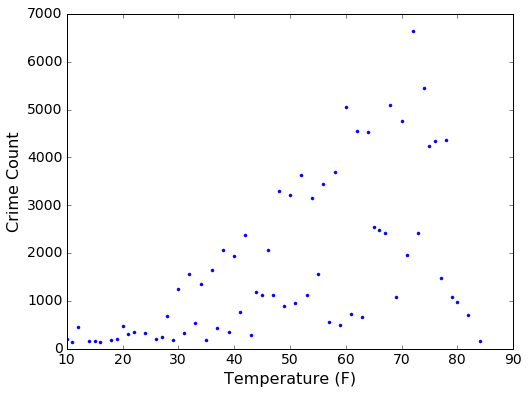

In [6]:
x = grouped.index
y = grouped._id.loc[:,'count'].values
plt.plot(x,y,'.')
plt.xlabel('Temperature (F)')
plt.ylabel('Crime Count')

We will use the Pearson product-moment correlation coefficient to measure the linear dependence between X and Y. 

In [7]:
print sc.pearsonr(x,y)

(0.58786924163197674, 1.0908233638972888e-07)


Given our small sample size of only 1-2 years worth of data, a pearson coefficient of 0.59 tells us there is a relatively strong linear correlation between temperature and crime. This indicates that it is more likely for violent crime to occur when the temperature is warmer and so may be a useful variable to take into account in our model.

Next, let's look at the five other variables we mentioned. For weather we will simply map the 10 possible "weather events" into an integer value (0 to Clear, 1 to Fog, etc.). 

For Hours of the day and season, we will treat the variables simply as categorical indicator vairables. For the rest of the data that is time based data however, we will instead treat them as cyclical variables using the formula;

$time = \sin\left(2\pi \frac{f}{N}\right)$

In [8]:
data.set_index('ARREST_TIME', inplace=True)

In [9]:
# Indicator time data
data['hour'] = data.index.hour # Starting at Midnight=0
data['season'] = data.index.month-1 # Starting at January=0

# Mapping time data to be cyclic
data['time'] = np.sin(2*np.pi*(data.index.hour * 60 + data.index.minute / float(60*24)))
data['day'] = np.sin(2*np.pi*data.index.weekday / float(7))

# Mapping weather to be numeric and categorical
D = {}
weather = np.unique(data[' Events'])
for i in xrange(0,len(weather)):
    D[weather[i]] = i
data['weather'] = data[' Events'].apply(lambda x: D[x])

C:\Users\Voskuil\Anaconda2\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


Now, we can group the data as we did before with temperature and examine the relationship each of these predictors have with crime frequency.

With the plots below there appears to be a few interesting relationships.

First we see a notable increase in crime during the summer months and a massive drop in crime in the winter months, this seems to confirm the relationship we noticed with temperature before and while this may issues of collinearity later it would be wise to utilize this data.

Second, hour and time give similar indication of 'high-crime' peaks and 'low-crime' troughs throughout the day, with hours showing a strong uptick during return-commute times, and near midnight and a drop off in the early morning hours, while the more detailed time data (taking into account minutes and hours) shows a more interesting pattern of crime upticks nearly every hour.

Finally, we can examine the day and weather event variables. Day does not appear to indicate any notable pattern besides an uptick in the middle of the week, while weather seems to indicate low crime most of the time except during rainy (=6) and clear (=0) days. This however may be a result of the other weather are considerably less likely to occur any may be affecting its importance.

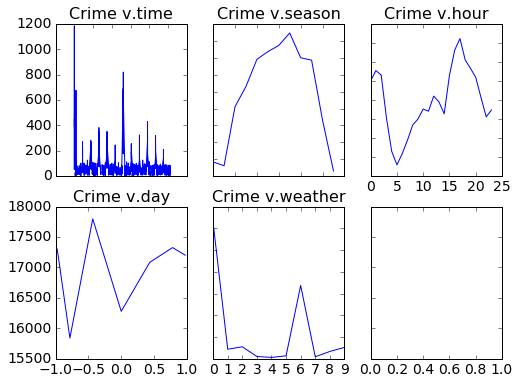

In [10]:
# Subplot variables
f, axarr = plt.subplots(2, 3)
preds = ['time','day','season','weather','hour']
for i in xrange(0,5):
    grouped = data.groupby(preds[i]).agg(['count'])
    x = grouped.index
    y = grouped._id.loc[:,'count'].values
    axarr[i%2,i/2].plot(x, y)
    axarr[i%2,i/2].set_title("Crime v." + preds[i])
a = plt.setp([a.get_xticklabels() for a in axarr[0, :2]], visible=False)
a = plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
a = plt.setp([a.get_yticklabels() for a in axarr[:, 2]], visible=False)

## Building A Regression Dataset

Now that we have thoroughly examined the data, we may now build our dataset for our regression model. To begin, our dataset has a lot of variables we do not need. We will begin by creating a new data set for the variables we will actually need. However, because the $time$ and $hour$ variables will almost assuredly lead to issues with collinearity we will instead elect to build two models, one using $time$, the other $hours$.

Currently our datasets only have the observed crimes. We will also need to change this to include a predictor, $Y$, to instead take into account the frequency of crimes grouped by the predictors of the two datasets.

In [11]:
# Cyclical Time grouped dataset
newData = pd.concat([data['time'], data['day'], data['season'], data['weather'], data['Mean TemperatureF'], data['_id']], axis=1)
groupedCrime = newData.groupby(['day','time','weather', 'season','Mean TemperatureF']).agg(['count'])

# Indicator Hour grouped dataset
newData2 = pd.concat([data['hour'], data['day'], data['season'], data['weather'], data['Mean TemperatureF'], data['_id']], axis=1)
groupedCrime2 = newData2.groupby(['hour','day','weather', 'season','Mean TemperatureF']).agg(['count'])

groupedCrime

_id
                                                         count
day       time          weather season Mean TemperatureF      
-0.974928 -1.175958e-12 0       0      38                    2
                                2      52                    1
                                4      56                    1
                                       76                    1
                                5      75                    8
                                       78                    1
                                6      72                    3
                                       73                    1
                                       75                    1
                                7      68                    6
                                       72                    1
                                8      65                    1
                                       66                    2
                                       67                    1
                                       72                    1
                                9      51                    2
                                10     48                    1
                                11     62                    2
                        1       5      67                    1
                                11     38                    5
                        2       6      71                    2
                        6       4      58                    1
                                5      70                    1
                                8      71                    1
                                9      47                    2
                                10     45                    1
                                       52                    1
                                11     52                    1
                        9       2      21                    1
                                       36                    2
...                                                        ...
 0.974928  2.546019e-01 6       6      68                    1
                                       68                    1
                                9      70                    1
                        0       8      68                    1
                                10     65                    1
                        6       10     59                    2
                        0       5      71                    2
                                6      80                    6
                                8      68                    2
                        6       4      72                    3
                                5      58                   14
                                9      70                    1
                        0       6      80                    1
                                8      65                    6
                        6       7      82                    3
                        0       5      74                    2
                        6       3      43                    1
                        0       2      62                    1
                                5      74                    5
                                2      60                    6
                                4      52                    1
                                7      73                    2
                                11     46                    3
                        6       8      60                    1
                        0       2      49                    2
                                6      68                    8
                        9       2      32                    1
                        0       10     48                    9
                        6       10     45                    1
                        0       10     45                    1

[54775 rows x 1 columns]

With a response variable, $Y$, we can now convert this grouped dataframe back to a dataframe that we can work with for our regression model.

Now that we have defined our two models we will then be able to begin building our model. For the sake of demonstration we will begin by building a model based upon the cyclical $time$ dataset. We will see later this model may prove problematic as an accurate predictor and for the lack of interpretability the coefficient of time can provide us.

In [12]:
# Build Cyclical-Time Regression Dataset
Y = groupedCrime._id.loc[:,'count'].values
nX = np.zeros((len(Y),5))
for i in xrange(0,len(Y)):
    #print groupedCrime.iloc[i].name
    nX[i] = np.array(groupedCrime.iloc[i].name)
X = pd.DataFrame(data=nX,columns=['Day','Time','Weather', 'Season','Temp'])
X['Crime'] = Y

# Build Indicator-Hour Regression Dataset
Y2 = groupedCrime2._id.loc[:,'count'].values
nX2 = np.zeros((len(Y2),5))
for i in xrange(0,len(Y2)):
    nX2[i] = np.array(groupedCrime2.iloc[i].name)
X2 = pd.DataFrame(data=nX2,columns=['Hour','Day','Weather', 'Season','Temp'])
X2['Crime'] = Y2

X

Day          Time  Weather  Season  Temp  Crime
0     -0.974928 -1.175958e-12      0.0     0.0  38.0      2
1     -0.974928 -1.175958e-12      0.0     2.0  52.0      1
2     -0.974928 -1.175958e-12      0.0     4.0  56.0      1
3     -0.974928 -1.175958e-12      0.0     4.0  76.0      1
4     -0.974928 -1.175958e-12      0.0     5.0  75.0      8
5     -0.974928 -1.175958e-12      0.0     5.0  78.0      1
6     -0.974928 -1.175958e-12      0.0     6.0  72.0      3
7     -0.974928 -1.175958e-12      0.0     6.0  73.0      1
8     -0.974928 -1.175958e-12      0.0     6.0  75.0      1
9     -0.974928 -1.175958e-12      0.0     7.0  68.0      6
10    -0.974928 -1.175958e-12      0.0     7.0  72.0      1
11    -0.974928 -1.175958e-12      0.0     8.0  65.0      1
12    -0.974928 -1.175958e-12      0.0     8.0  66.0      2
13    -0.974928 -1.175958e-12      0.0     8.0  67.0      1
14    -0.974928 -1.175958e-12      0.0     8.0  72.0      1
15    -0.974928 -1.175958e-12      0.0     9.0  51.0      2
16    -0.974928 -1.175958e-12      0.0    10.0  48.0      1
17    -0.974928 -1.175958e-12      0.0    11.0  62.0      2
18    -0.974928 -1.175958e-12      1.0     5.0  67.0      1
19    -0.974928 -1.175958e-12      1.0    11.0  38.0      5
20    -0.974928 -1.175958e-12      2.0     6.0  71.0      2
21    -0.974928 -1.175958e-12      6.0     4.0  58.0      1
22    -0.974928 -1.175958e-12      6.0     5.0  70.0      1
23    -0.974928 -1.175958e-12      6.0     8.0  71.0      1
24    -0.974928 -1.175958e-12      6.0     9.0  47.0      2
25    -0.974928 -1.175958e-12      6.0    10.0  45.0      1
26    -0.974928 -1.175958e-12      6.0    10.0  52.0      1
27    -0.974928 -1.175958e-12      6.0    11.0  52.0      1
28    -0.974928 -1.175958e-12      9.0     2.0  21.0      1
29    -0.974928 -1.175958e-12      9.0     2.0  36.0      2
...         ...           ...      ...     ...   ...    ...
54745  0.974928  2.546019e-01      6.0     6.0  68.0      1
54746  0.974928  2.546019e-01      6.0     6.0  68.0      1
54747  0.974928  2.546019e-01      6.0     9.0  70.0      1
54748  0.974928  2.546019e-01      0.0     8.0  68.0      1
54749  0.974928  2.546019e-01      0.0    10.0  65.0      1
54750  0.974928  2.546019e-01      6.0    10.0  59.0      2
54751  0.974928  2.546019e-01      0.0     5.0  71.0      2
54752  0.974928  2.546019e-01      0.0     6.0  80.0      6
54753  0.974928  2.546019e-01      0.0     8.0  68.0      2
54754  0.974928  2.546019e-01      6.0     4.0  72.0      3
54755  0.974928  2.546019e-01      6.0     5.0  58.0     14
54756  0.974928  2.546019e-01      6.0     9.0  70.0      1
54757  0.974928  2.546019e-01      0.0     6.0  80.0      1
54758  0.974928  2.546019e-01      0.0     8.0  65.0      6
54759  0.974928  2.546019e-01      6.0     7.0  82.0      3
54760  0.974928  2.546019e-01      0.0     5.0  74.0      2
54761  0.974928  2.546019e-01      6.0     3.0  43.0      1
54762  0.974928  2.546019e-01      0.0     2.0  62.0      1
54763  0.974928  2.546019e-01      0.0     5.0  74.0      5
54764  0.974928  2.546019e-01      0.0     2.0  60.0      6
54765  0.974928  2.546019e-01      0.0     4.0  52.0      1
54766  0.974928  2.546019e-01      0.0     7.0  73.0      2
54767  0.974928  2.546019e-01      0.0    11.0  46.0      3
54768  0.974928  2.546019e-01      6.0     8.0  60.0      1
54769  0.974928  2.546019e-01      0.0     2.0  49.0      2
54770  0.974928  2.546019e-01      0.0     6.0  68.0      8
54771  0.974928  2.546019e-01      9.0     2.0  32.0      1
54772  0.974928  2.546019e-01      0.0    10.0  48.0      9
54773  0.974928  2.546019e-01      6.0    10.0  45.0      1
54774  0.974928  2.546019e-01      0.0    10.0  45.0      1

[54775 rows x 6 columns]

## Building A Linear Regression Model

Now that we have a dataset we want to work with we can now begin building our linear regression model. To do this we will be using the useful statsmodel library to build a regression model. For our first model we will begin by simply building an ordinary least square model based upon the factors we mentioned above. 

In [13]:
# Build OLS Linear Regression Model
reg = smf.ols('Crime ~ Day + Time + Weather + Season + Temp', data=X).fit()
#reg4 = smf.glm(formula='Crime ~ Day + Time + Weather + Season + Temp', data=X, family=sm.families.NegativeBinomial()).fit()
print (reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Crime   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     16.03
Date:                Sat, 10 Dec 2016   Prob (F-statistic):           8.11e-16
Time:                        16:34:11   Log-Likelihood:            -1.2301e+05
No. Observations:               54775   AIC:                         2.460e+05
Df Residuals:                   54769   BIC:                         2.461e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.1293      0.045     47.576      0.0

This summary tells us that the overall model appears to be correct with a signifiantly low model p-value and that temperature appears to be significant and has a positive relationship with crime frequency.

However, the AIC is rather large for our model and the $Day$ variable does not seem to be a statistically significant predictor, but we will perform some diagnostics before making any conclusions.

## Diagnostics

Now that we have a model fitted, we need to see if we can actually use this model to make any worthwhile conclusions. To do this will examine the residuals to see whether our assumptions about linear regression hold, namely that;

- Little or no Multicollinarity
- Residuals are normally distributed.
- Residuals have constant variance about zero.

We will begin by examining the condition of normality using a qqplot, a residuals plot

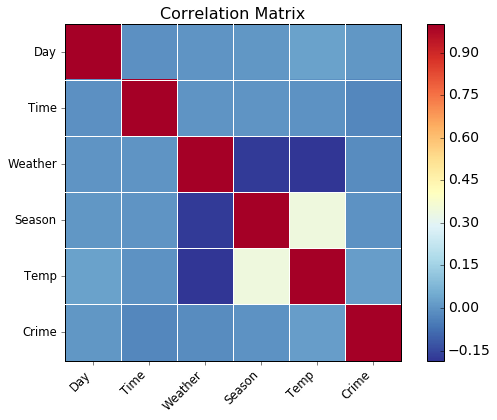

In [26]:
# Correlation Plot for testing multicollinarity
corr_matrix = np.corrcoef(X.T)
sm.graphics.plot_corr(corr_matrix,xnames=list(X.columns))
plt.show()

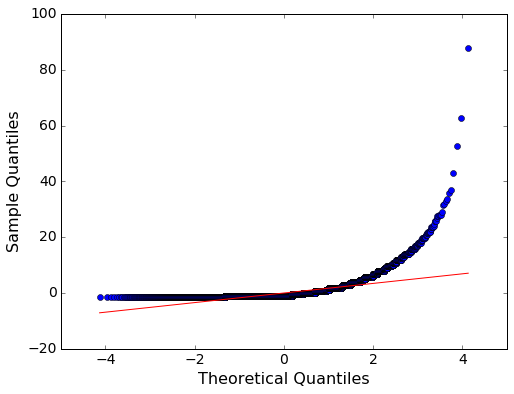

In [27]:
#Q-Q plot for testing normality
fig1=sm.qqplot(reg.resid, line='r')

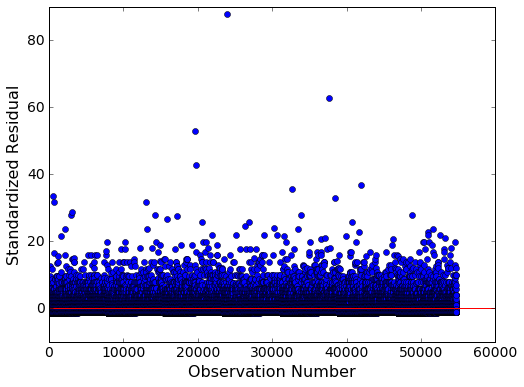

In [28]:
# Simple plot of residuals
stdres=pd.DataFrame(reg.resid)
fig2 = plt.plot(stdres, 'o', ls='None')
l = plt.axhline(y=0, color='r')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')

With these plots, while our model does not seem to suffer terribly from multi-collinarity, it's evident that our model displays terrible fit, with incredibly large residuals certainly not centered about zero. It's also clear from the q-q plot that our model clearly does not display normality.

To understand this it may be useful to look to look at the histogram of the crime frequency data we wish to predict.

(array([  4.15790000e+04,   7.99200000e+03,   2.76100000e+03,
          1.20900000e+03,   2.45000000e+02,   4.26000000e+02,
          2.42000000e+02,   1.20000000e+02,   8.10000000e+01,
          2.90000000e+01,   3.20000000e+01,   1.80000000e+01,
          1.30000000e+01,   2.00000000e+00,   6.00000000e+00,
          4.00000000e+00,   6.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

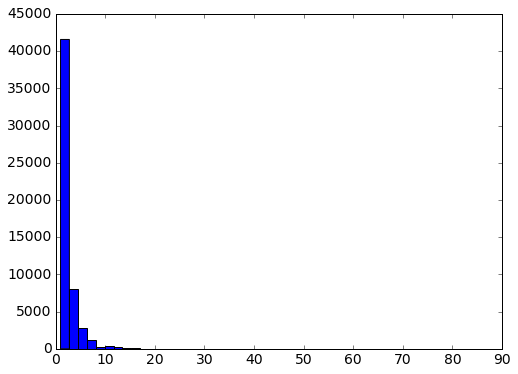

In [29]:
plt.hist(Y,bins=50)

Clearly with our data set we have some notable outliers that we will have to take into accound while improving our model.

## Improving The Model

### Improving The Regression

So our first model appears to have been a dud. What do we do now?

Well, one of the most notable findings in our diagnostic plots was that the residuals did not appear to be normally distributed but instead almost seemed to fit an exponential distribution. One of the first steps then we may want to consider is simply modifying the model itself.

To do this, we will instead of using ordinary least square regression, will instead elect to use a generalized linear model with an exponential family likelihood function. In this case, we will use the gamma distribution from the exponential family to fit a new model.

In [32]:
reg2 = smf.glm(formula='Crime ~ Day + Time + Weather + Season + Temp', data=X, family=sm.families.Gamma()).fit()
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Crime   No. Observations:                54775
Model:                            GLM   Df Residuals:                    54769
Model Family:                   Gamma   Df Model:                            5
Link Function:          inverse_power   Scale:                   1.10847702274
Method:                          IRLS   Log-Likelihood:                -98931.
Date:                Sat, 10 Dec 2016   Deviance:                       30623.
Time:                        16:53:29   Pearson chi2:                 6.07e+04
No. Iterations:                     8                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.4708      0.010     48.979      0.000         0.452     0.490
Day           -0.0034      0.003     -1.147      0.251        -0.009     0.002
Time           0.1671      0.027      6.213      0.000         0.114     0.220
Weather        0.0020      0.001      2.992      0.003         0.001     0.003
Season         0.0020      0.001      2.650      0.008         0.001     0.003
Temp          -0.0008      0.000     -5.110      0.000        -0.001    -0.000
==============================================================================
"""

One of the first improvements we see in the summary data is that deviance and log-likelihood both seem to be closer to zero which is an encouraging sign. To test our model we will again look to plot the residuals as we did before for diagnostic checks.

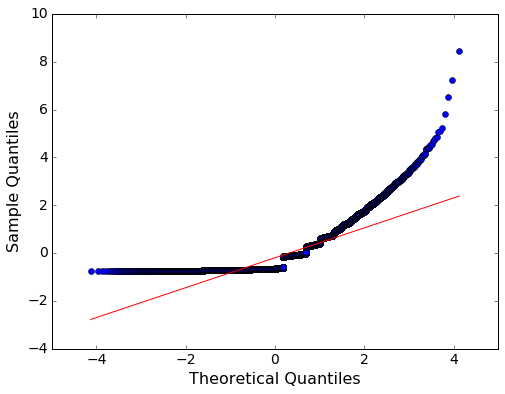

In [33]:
#Q-Q plot for normality
fig1=sm.qqplot(reg2.resid_deviance, line='r')

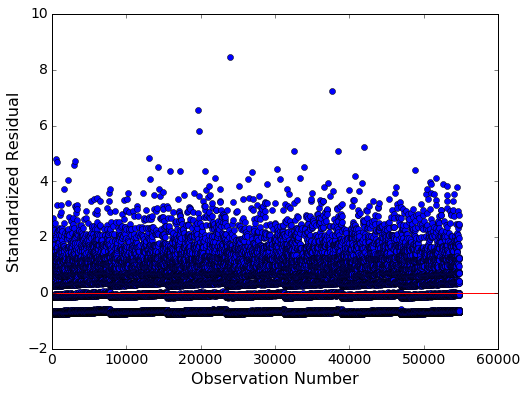

In [34]:
# simple plot of residuals
stdres=pd.DataFrame(reg2.resid_deviance)
fig2 = plt.plot(stdres, 'o', ls='None')
l = plt.axhline(y=0, color='r')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')

Looking at the residual plots its clear we have some notable improvements. The magnitude of the residuals seems more concentrated in the single digits and appear at least marginally more normal.

However, with that said the model is still not satisfactory. It's evident the residuals still do not follow normality and even more worrisome, while the residuals appear to be concentrated above zero, the residuals below seem to display a strange pattern.

What do we do now?

### Improving The Data

As we noted in the Diagnostic section, the data displays some notable outliers. Aside from that our data has a fair deal of problems.

For one, we still have some cyclical time-based data that gives us little in the way of interpretability. Second, variables like $Day$ have been shown to provide little significance in predicting crime. And finally leaving weather events as ordered categorical variables makes little intuitive sense.

To deal with these issues we can instead work with the $X_2$ data set using the hours variable and fix up some of the data.

The first step we can do is modify our $Day$ variable.

In [298]:
a = pd.get_dummies(X2.Day)
a.columns = ['Saturday',"Sunday","Monday","Tuesday","Wednesday","Thursday","Friday"]
b = []
for i,trial in a.iterrows():
    if (a.iloc[i,0]==1.0 or a.iloc[i,1]==1.0):
        b.append(1.0)
    else:
        b.append(0.0)
X2.Day = b


c = pd.get_dummies(X2.Weather)
c.columns = ['Clear','Fog','Fog-Rain','Fog-Rain-Snow','Fog-Rain-Thunderstorm','Fog-Snow','Rain','Rain-Snow','Rain-Thunderstorm','Snow']
rain = []
snow = []
for i,trial in c.iterrows():
    if (c.iloc[i,0]==1.0 or c.iloc[i,1]==1.0):
        rain.append(0.0)
        snow.append(0.0)
    elif (c.iloc[i,2]==1.0 or c.iloc[i,4]==1.0 or c.iloc[i,6]==1.0 or c.iloc[i,8]==1.0):
        rain.append(1.0)
        snow.append(0.0)
    else:
        rain.append(0.0)
        snow.append(1.0)
X2['Rain'] = rain
X2['Snow'] = snow


e = pd.get_dummies(X2.Season)
e.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fall = []
winter = []
spring = []
for i,trial in e.iterrows():
    if (e.iloc[i,8]==1.0 or e.iloc[i,9]==1.0 or e.iloc[i,10]==1.0):
        fall.append(1.0)
        winter.append(0.0)
        spring.append(0.0)
    elif (e.iloc[i,11]==1.0 or e.iloc[i,0]==1.0 or e.iloc[i,1]==1.0):
        fall.append(0.0)
        winter.append(1.0)
        spring.append(0.0)
    elif (e.iloc[i,2]==1.0 or e.iloc[i,3]==1.0 or e.iloc[i,4]==1.0):
        fall.append(0.0)
        winter.append(0.0)
        spring.append(1.0)
    else:
        fall.append(0.0)
        winter.append(0.0)
        spring.append(0.0)
X2['Fall'] = fall
X2['Winter'] = winter
X2['Spring'] = spring

In [299]:
del X2['Weather']
del X2['Season']
f = pd.get_dummies(X2.Hour)
f.columns = ['Midnight','One','Two','Three','Four','Five','Six','Seven','Eight',
             'Nine','Ten','Eleven','Twelve','Thirteen','Fourteen','Fifteen',
             'Sixteen','Seventeen','Eighteen','Nineteen','Twenty','Twentyone',
             'Twentytwo','Twentythree']
for x in f.columns:
    X2[x] = f[x]
del X2['Hour']
X2

Day  Temp  Crime  Rain  Snow  Fall  Winter  Spring  Midnight  One  \
0      1.0  38.0     10   0.0   0.0   0.0     1.0     0.0       1.0  0.0   
1      1.0  34.0     11   0.0   0.0   0.0     1.0     0.0       1.0  0.0   
2      1.0  36.0      5   0.0   0.0   0.0     1.0     0.0       1.0  0.0   
3      1.0  60.0     19   0.0   0.0   0.0     1.0     0.0       1.0  0.0   
4      1.0  44.0     24   0.0   0.0   0.0     0.0     1.0       1.0  0.0   
5      1.0  46.0     25   0.0   0.0   0.0     0.0     1.0       1.0  0.0   
6      1.0  52.0     11   0.0   0.0   0.0     0.0     1.0       1.0  0.0   
7      1.0  49.0     23   0.0   0.0   0.0     0.0     1.0       1.0  0.0   
8      1.0  55.0     10   0.0   0.0   0.0     0.0     1.0       1.0  0.0   
9      1.0  60.0      7   0.0   0.0   0.0     0.0     1.0       1.0  0.0   
10     1.0  63.0     23   0.0   0.0   0.0     0.0     1.0       1.0  0.0   
11     1.0  56.0     18   0.0   0.0   0.0     0.0     1.0       1.0  0.0   
12     1.0  60.0     26   0.0   0.0   0.0     0.0     1.0       1.0  0.0   
13     1.0  75.0     10   0.0   0.0   0.0     0.0     1.0       1.0  0.0   
14     1.0  76.0     17   0.0   0.0   0.0     0.0     1.0       1.0  0.0   
15     1.0  73.0     30   0.0   0.0   0.0     0.0     0.0       1.0  0.0   
16     1.0  75.0     14   0.0   0.0   0.0     0.0     0.0       1.0  0.0   
17     1.0  78.0     35   0.0   0.0   0.0     0.0     0.0       1.0  0.0   
18     1.0  64.0     16   0.0   0.0   0.0     0.0     0.0       1.0  0.0   
19     1.0  72.0     18   0.0   0.0   0.0     0.0     0.0       1.0  0.0   
20     1.0  73.0     11   0.0   0.0   0.0     0.0     0.0       1.0  0.0   
21     1.0  75.0     12   0.0   0.0   0.0     0.0     0.0       1.0  0.0   
22     1.0  76.0     22   0.0   0.0   0.0     0.0     0.0       1.0  0.0   
23     1.0  80.0     46   0.0   0.0   0.0     0.0     0.0       1.0  0.0   
24     1.0  68.0     35   0.0   0.0   0.0     0.0     0.0       1.0  0.0   
25     1.0  72.0     20   0.0   0.0   0.0     0.0     0.0       1.0  0.0   
26     1.0  74.0     41   0.0   0.0   0.0     0.0     0.0       1.0  0.0   
27     1.0  77.0     17   0.0   0.0   0.0     0.0     0.0       1.0  0.0   
28     1.0  65.0     20   0.0   0.0   1.0     0.0     0.0       1.0  0.0   
29     1.0  66.0     16   0.0   0.0   1.0     0.0     0.0       1.0  0.0   
...    ...   ...    ...   ...   ...   ...     ...     ...       ...  ...   
13068  0.0  76.0      8   0.0   0.0   0.0     0.0     0.0       0.0  0.0   
13069  0.0  64.0      5   1.0   0.0   0.0     0.0     1.0       0.0  0.0   
13070  0.0  45.0      1   1.0   0.0   0.0     1.0     0.0       0.0  0.0   
13071  0.0  31.0     17   0.0   1.0   0.0     1.0     0.0       0.0  0.0   
13072  0.0  56.0      8   1.0   0.0   0.0     1.0     0.0       0.0  0.0   
13073  0.0  50.0      2   1.0   0.0   0.0     0.0     1.0       0.0  0.0   
13074  0.0  43.0      2   1.0   0.0   0.0     0.0     1.0       0.0  0.0   
13075  0.0  50.0     14   1.0   0.0   0.0     0.0     1.0       0.0  0.0   
13076  0.0  52.0      4   1.0   0.0   0.0     0.0     1.0       0.0  0.0   
13077  0.0  55.0      2   1.0   0.0   0.0     0.0     1.0       0.0  0.0   
13078  0.0  72.0     17   1.0   0.0   0.0     0.0     1.0       0.0  0.0   
13079  0.0  58.0      9   1.0   0.0   0.0     0.0     0.0       0.0  0.0   
13080  0.0  73.0      4   1.0   0.0   0.0     0.0     0.0       0.0  0.0   
13081  0.0  68.0      4   1.0   0.0   0.0     0.0     0.0       0.0  0.0   
13082  0.0  79.0      1   1.0   0.0   0.0     0.0     0.0       0.0  0.0   
13083  0.0  72.0      9   1.0   0.0   0.0     0.0     0.0       0.0  0.0   
13084  0.0  82.0     15   1.0   0.0   0.0     0.0     0.0       0.0  0.0   
13085  0.0  60.0     31   1.0   0.0   1.0     0.0     0.0       0.0  0.0   
13086  0.0  58.0     10   1.0   0.0   1.0     0.0     0.0       0.0  0.0   
13087  0.0  70.0      9   1.0   0.0   1.0     0.0     0.0       0.0  0.0   
13088  0.0  45.0      8   1.0   0.0   1.0     0.0     0

In [316]:
#reg3b = smf.glm('Crime ~ Day + One + Two + Three + Four + Five + Six + Seven + Eight + Nine + Ten + Eleven + Twelve + Thirteen + Fourteen + Fifteen + Sixteen + Seventeen + Eighteen + Nineteen + Twenty + Twentyone + Twentytwo + Twentythree + Rain + Snow + Fall + Winter + Spring', data=X2).fit()
reg3b = smf.ols('Crime ~ Day + One + Two + Three + Four + Five + Six + Seven + Eight + Nine + Ten + Eleven + Twelve + Thirteen + Fourteen + Fifteen + Sixteen + Seventeen + Eighteen + Nineteen + Twenty + Twentyone + Twentytwo + Twentythree + Rain + Snow + Fall + Winter + Spring + Temp', data=X2).fit()
print (reg3b.summary())

                            OLS Regression Results                            
Dep. Variable:                  Crime   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     71.16
Date:                Sat, 10 Dec 2016   Prob (F-statistic):               0.00
Time:                        15:17:59   Log-Likelihood:                -44542.
No. Observations:               13098   AIC:                         8.915e+04
Df Residuals:                   13067   BIC:                         8.938e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      10.6727      0.604     17.656      

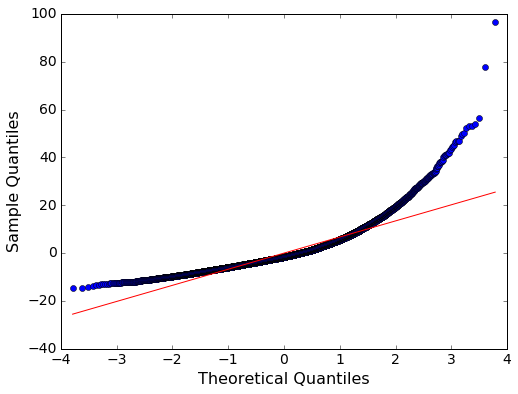

In [317]:
#Q-Q plot for normality
fig1=sm.qqplot(reg3b.resid, line='r')

In [318]:
reg3b = smf.glm('Crime ~ Day + One + Two + Three + Four + Five + Six + Seven + Eight + Nine + Ten + Eleven + Twelve + Thirteen + Fourteen + Fifteen + Sixteen + Seventeen + Eighteen + Nineteen + Twenty + Twentyone + Twentytwo + Twentythree + Rain + Snow + Fall + Winter + Spring', data=X2,family=sm.families.Gamma()).fit()
reg3b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Crime   No. Observations:                13098
Model:                            GLM   Df Residuals:                    13068
Model Family:                   Gamma   Df Model:                           29
Link Function:          inverse_power   Scale:                  0.635700152874
Method:                          IRLS   Log-Likelihood:                -40057.
Date:                Sat, 10 Dec 2016   Deviance:                       7638.3
Time:                        15:18:33   Pearson chi2:                 8.31e+03
No. Iterations:                     8                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.0811      0.003     24.077      0.000         0.075     0.088
Day             0.0051      0.002      3.077      0.002         0.002     0.008
One            -0.0092      0.004     -2.179      0.029        -0.018    -0.001
Two            -0.0083      0.004     -1.936      0.053        -0.017     0.000
Three           0.0345      0.005      6.322      0.000         0.024     0.045
Four            0.1178      0.008     14.264      0.000         0.102     0.134
Five            0.1861      0.011     16.893      0.000         0.165     0.208
Six             0.1377      0.009     15.661      0.000         0.121     0.155
Seven           0.0928      0.007     13.008      0.000         0.079     0.107
Eight           0.0562      0.006      9.405      0.000         0.044     0.068
Nine            0.0460      0.006      8.132      0.000         0.035     0.057
Ten             0.0295      0.005      5.663      0.000         0.019     0.040
Eleven          0.0334      0.005      6.291      0.000         0.023     0.044
Twelve          0.0133      0.005      2.786      0.005         0.004     0.023
Thirteen        0.0202      0.005      4.085      0.000         0.011     0.030
Fourteen        0.0350      0.005      6.512      0.000         0.024     0.046
Fifteen        -0.0041      0.004     -0.945      0.345        -0.013     0.004
Sixteen        -0.0191      0.004     -4.781      0.000        -0.027    -0.011
Seventeen      -0.0246      0.004     -6.340      0.000        -0.032    -0.017
Eighteen       -0.0147      0.004     -3.577      0.000        -0.023    -0.007
Nineteen       -0.0089      0.004     -2.113      0.035        -0.017    -0.001
Twenty         -0.0033      0.004     -0.752      0.452        -0.012     0.005
Twentyone       0.0133      0.005      2.778      0.005         0.004     0.023
Twentytwo       0.0351      0.005      6.442      0.000         0.024     0.046
Twentythree     0.0286      0.005      5.483      0.000         0.018     0.039
Rain            0.0063      0.002      4.019      0.000         0.003     0.009
Snow            0.0143      0.003      4.179      0.000         0.008     0.021
Fall            0.0079      0.002      4.256      0.000         0.004     0.012
Winter          0.0164      0.003      6.338      0.000         0.011     0.021
Spring          0.0136      0.002      6.980      0.000         0.010     0.017
===============================================================================
"""

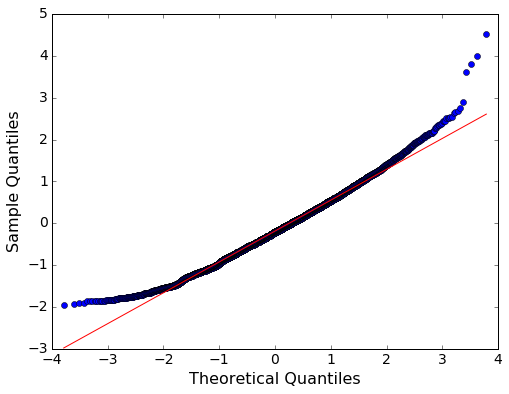

In [314]:
#Q-Q plot for normality
#reg2.resid_deviance
fig1=sm.qqplot(reg3b.resid_deviance, line='r')

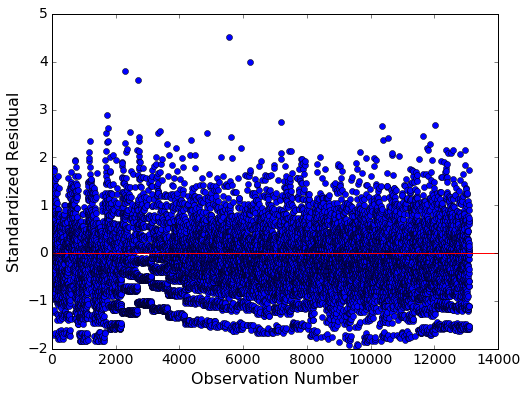

In [319]:
stdres=pd.DataFrame(reg3b.resid_deviance)
fig2 = plt.plot(stdres, 'o', ls='None')
l = plt.axhline(y=0, color='r')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')

## Putting it All Together